In [188]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, List, Any
import random
%matplotlib inline

In [189]:
def f(x):
    return 3*x**2 -4*x + 5

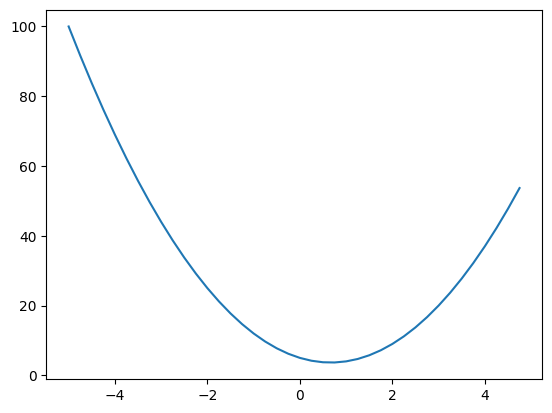

In [190]:
f(3.0)
xs = np.arange(-5, 5, 0.25)
plt.plot(xs, f(xs))

In [191]:
h = 0.0001
x = 3.0
(f(x + h) - f(x)) / h

14.000300000063248

_children adds information about what values were used to create this current node
that information is mandatory in order to calculate gradients


In [192]:
class Value:
    def __init__(self, data, _children=(), _op="", label=None) -> None:
        self.data = data
        self.grad = 0.0 # gradient with respect to output
        self._backward = lambda: None # no gradients to set on a leaf node
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: Union['Value', float]) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        # when backward is called, gradients of the previous nodes are calculated
        # it doesn't calculate the gradient of the node that called backward
        def _backward(): 
            self.grad += 1.0 * out.grad # gradients accumulated
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    def __radd__(self, other: float) -> 'Value':
        return self.__add__(other)
    
    def __mul__(self, other: Union['Value', float]) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward(): # the base case out.grad is 1. recursive case works. induction magic. 
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    def __rmul__(self, other: float) -> 'Value':
        return self * other
    
    def __neg__(self) -> 'Value':
        return self * -1
    def __sub__(self, other: Union['Value', float]) -> 'Value':
        return self + (-other)
    def __rsub__(self, other: float) -> 'Value':
        return self + (-other)
    
    def __pow__(self, other: Union[int, float]) -> 'Value':
        assert isinstance(other, (int, float)) # we don't need to calculate gradient for other
        out = Value(self.data ** other, (self,), f"**{other}")
        
        def _backward():
            self.grad = out.grad * (other * self.data ** (other - 1))
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other: Union['Value', float]) -> 'Value':
        other = other if isinstance(other, Value) else Value(other)
        
        return self * (other ** -1)
    
    def exp(self) -> 'Value':
        out = Value(math.exp(self.data), (self,), "exp")
        
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        
        return out
    
    def tanh(self) -> 'Value':
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        
        def _backward():
            self.grad += out.grad * (1 - out.data**2)
        out._backward = _backward
        
        return out
    
    def backward(self):
        nodes = []
        visited = set()
        def topological_sort(node: Value):
            if node not in visited:
                visited.add(node)
                for child_node in node._prev:
                    topological_sort(child_node)
                nodes.append(node)
        topological_sort(self)
        
        self.grad = 1.0
        for node in reversed(nodes):
            node._backward()

In [193]:
# visualization
from graphviz import Digraph

def trace(root: Value):
    nodes: set[Value] = set()
    edges: set[tuple[Value, Value]] = set()
    
    def travel_to(node: Value):
        if node not in nodes:
            nodes.add(node)
            for child_node in node._prev:
                edges.add((child_node, node))
                travel_to(child_node)
    travel_to(root)
    
    return nodes, edges

def visualize(root: Value):
    visualization = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for node in nodes:
        node_id = str(id(node))
        visualization.node(name=node_id, label="{%s | data %.4f | grad %.4f}" % (node.label, node.data, node.grad), shape="record")
        if node._op: 
            # if this node came about an operation, we want to describe that through creating & linking an operation node
            visualization.node(name=f"{node_id}_{node._op}", label=node._op)
            visualization.edge(f"{node_id}_{node._op}", node_id)
            
    # only nodes involved in operations are described through edges
    for edge in edges:
        node1, node2 = edge
        visualization.edge(str(id(node1)), f"{str(id(node2))}_{node2._op}") # link to op node
        
    return visualization


In [194]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")

# forward pass
w1x1 = w1 * x1; w1x1.label = "w1x1"
w2x2 = w2 * x2; w2x2.label = "w2x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1x1 + w2x2"
n = w1x1w2x2 + b; n.label = "n"
# o = n.tanh(); print(o); o.label = "o"
o = ((2*n).exp() - 1) / ((2*n).exp() + 1); o.label = "o"
o.backward()

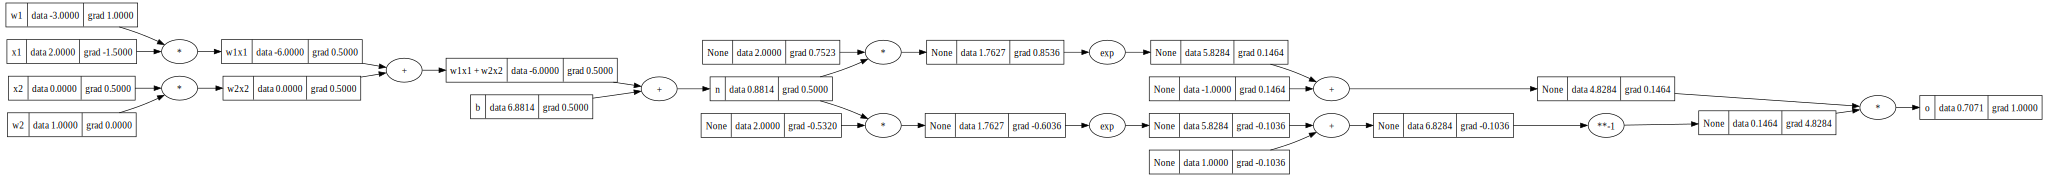

In [195]:
visualize(o)

In [196]:
# depth first travesal (kinda?)
# this has problems later on
# if we're using a MLP where multiple inputs lead to multiple outputs, 
def backward_motherfuckers(node: Value):
    node._backward()
    for prev_node in node._prev:
        backward_motherfuckers(prev_node)
        
o.grad = 1.0
backward_motherfuckers(o)

In [197]:
# topological sort
# we want to go down layer by layer
nodes = []
visited = set()
def topological_sort(node: Value):
    if node not in visited:
        visited.add(node)
        for child_node in node._prev:
            topological_sort(child_node)
        nodes.append(node)
    
topological_sort(o)
nodes

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=2),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=-1),
 Value(data=4.828427124746192),
 Value(data=2),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=0.7071067811865477)]

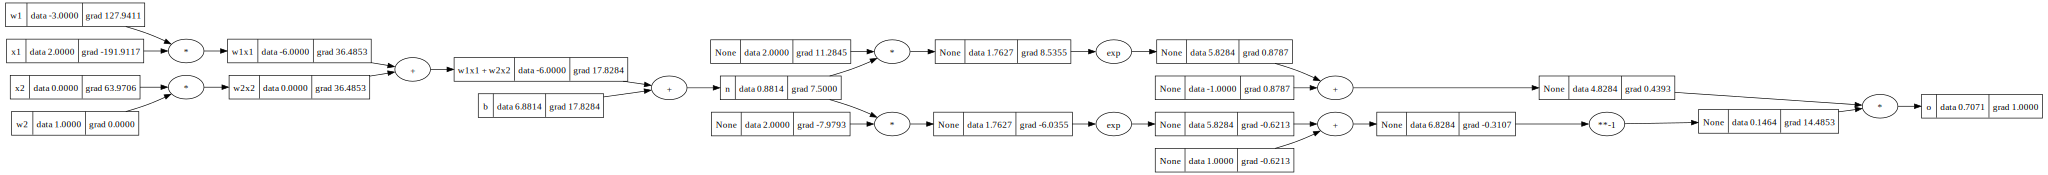

In [198]:
o.backward()
visualize(o)

In [230]:
class Neuron:
    def __init__(self, num_inputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x: List[float]):
        # zip turns interators into another iterator of tuples
        act = sum([wi*xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self) -> List[Value]:
        return self.w + [self.b]

class Layer:
    def __init__(self, num_inputs, num_neurons):
        self.neurons = [Neuron(num_inputs) for _ in range(num_neurons)]
    
    # x is output of previous layer
    # everything in the previous layer is fed into each neuron
    def __call__(self, x: List): 
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self) -> List[Value]:
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    # outputs of previous layers are fed into every neuron in the next layer
    # the number of neurons in the next layer determine the output size of that layer
    def __init__(self, layer_info):
        self.layers = [
            Layer(
                layer_info[idx], 
                layer_info[idx+1]
            ) for idx in range(len(layer_info)-1)
        ]
        
    def __call__(self, x: List):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out
    
    def parameters(self) -> List[Value]:
        return [p for layer in self.layers for p in layer.parameters()]
        
x = [2.0, 3.0, 4.0]
mlp = MLP([3, 4, 4, 1])
mlp_out = mlp(x)

In [231]:
len(mlp.parameters())

41

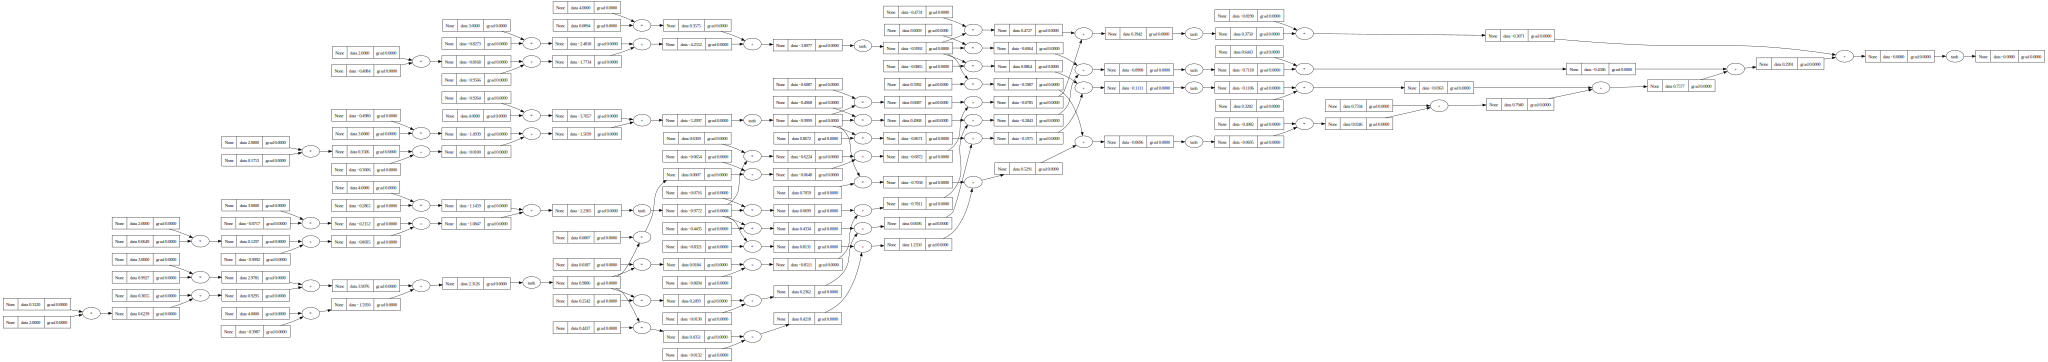

In [200]:
visualize(mlp_out)

In [233]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred: List[Value] = [mlp(x) for x in xs] # type: ignore
ypred

[Value(data=-0.059425353718697733),
 Value(data=-0.119553391129066),
 Value(data=0.001753283650622626),
 Value(data=-0.05358620323922135)]

In [234]:
loss: Value = sum([(y - yhat)**2 for y, yhat in zip(ys, ypred)]) # type: ignore
loss

Value(data=4.011121840135157)

In [223]:
loss.backward()

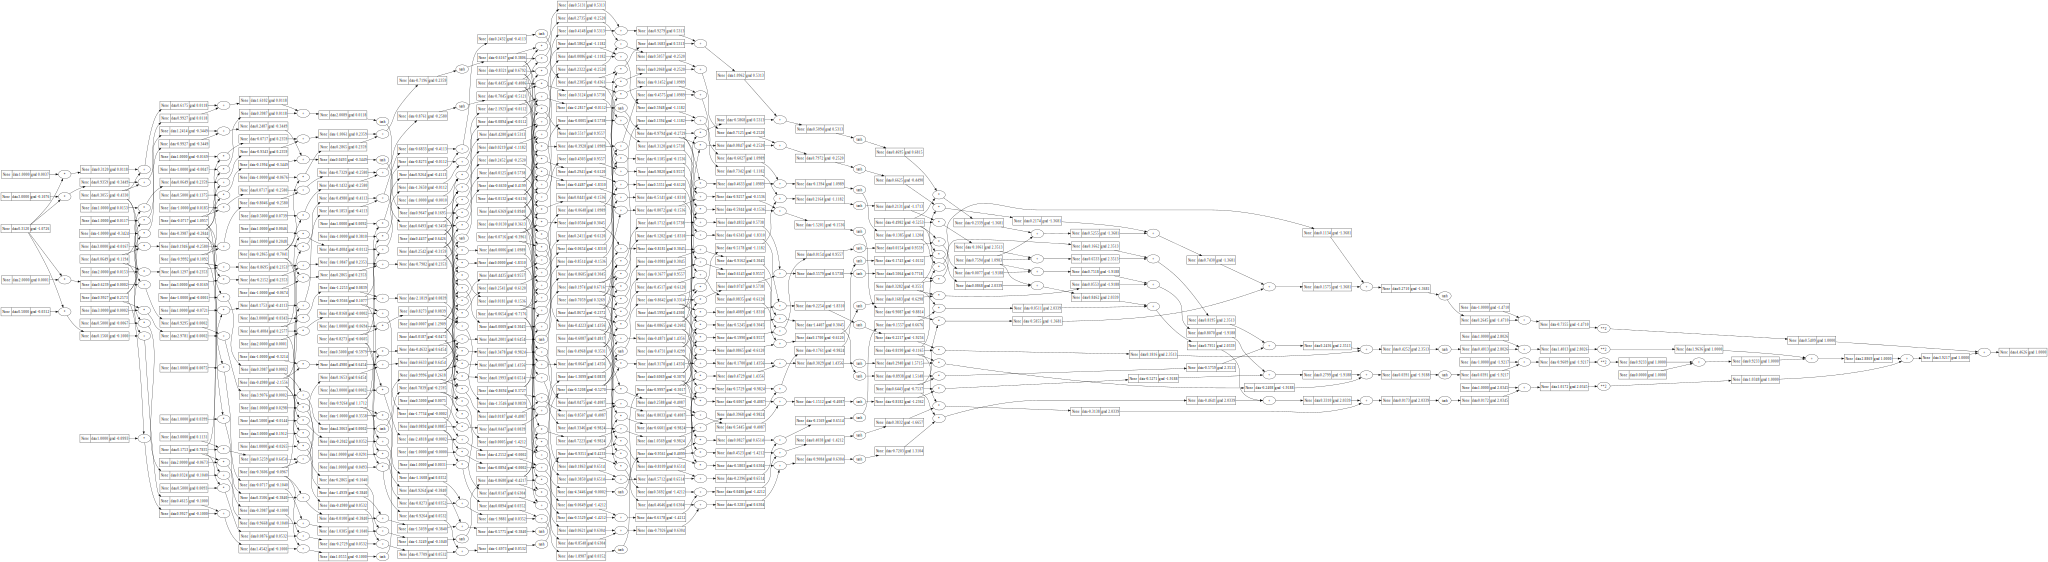

In [210]:
visualize(loss)

In [224]:
for p in mlp.parameters():
    p.data -= 0.01 * p.grad

In [244]:
for _ in range(100):
    ypred: List[Value] = [mlp(x) for x in xs] # type: ignore
    loss: Value = sum([(y - yhat)**2 for y, yhat in zip(ys, ypred)]) # type: ignore
    
    # zero grad - how did it still work without this? 
    # so it seems that the rapid convergence last time was due to not flushing gradients
    # so the gradients were accumulating and grew huge
    # the only reason why it worked for this problem is because the problem is extremely easy to fit
    # even with massive movements in what could very well be the wrong direction, still managed to converge to something that worked. 
    # need to be very careful when training neural nets. If you make a subtle bug, things could still seemingly work, until 3 months down the line you realize you're a dumbass
    for p in mlp.parameters():
        p.grad = 0
    
    loss.backward()
    for p in mlp.parameters():
        p.data -= 0.01 * p.grad
    
loss: Value = sum([(y - yhat)**2 for y, yhat in zip(ys, ypred)]) # type: ignore
print(loss)

Value(data=0.002905628007692318)


In [228]:
mlp.parameters()

[Value(data=-8.963646185699082),
 Value(data=11.017211029170086),
 Value(data=-12.202794186785031),
 Value(data=-6.063850933748991),
 Value(data=1.253297351635334),
 Value(data=-0.3361410970680291),
 Value(data=1.501541813051507),
 Value(data=0.7976235535563773),
 Value(data=7.625785005204532),
 Value(data=9.22266643578171),
 Value(data=-8.072923870831767),
 Value(data=3.0628368243243185),
 Value(data=-2.4551375765142036),
 Value(data=10.946328723390968),
 Value(data=-1.5675817284624447),
 Value(data=2.527455566667396),
 Value(data=-1.5380480682751057),
 Value(data=4.2111693419382314),
 Value(data=0.8627715232276031),
 Value(data=-3.661815627844225),
 Value(data=3.96221819506678),
 Value(data=6.23471316283453),
 Value(data=0.5738339473259478),
 Value(data=-3.602093286845333),
 Value(data=6.262446499692581),
 Value(data=-0.9195928464129802),
 Value(data=-7.397367601486324),
 Value(data=-0.3118283845326562),
 Value(data=1.8820518653114622),
 Value(data=-4.677282771361865),
 Value(data=-1

In [229]:
ypred

[Value(data=0.9997272011981961),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=0.9999979721032686)]

In [ ]:
# forward pass (calculate loss) -> backward pass [loss.backward()] (calculate gradients) -> update parameters w. gradient information
# really crazy to see how abstractions compound
# the graph fucking explodes in complexity
# the loss_visualization digraph is only on 41 parameters with 4 training examples
# imagine what it'd be like for 100billion parameter networks with the corpus of the internet as it's training data
# that's why tens of thousands of A100's can take months to train these. the scale is insane. 
# every single bit of extra training data creates errors which all combine into loss. A LOTTA GRADIENTS TO CALCULATE. gradient accumulation is something to pay close attention to